In [10]:
import carball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import requests
%matplotlib inline

In [267]:
def get_playergames(rank=19):
    url = "https://calculated.gg/api/v1/playergames?key=1&rank={}&playlist=13".format(rank)
    r = requests.get(url)
    return r.json()

def get_playergames_by_id(id_="76561198055442516"):
    url = "https://calculated.gg/api/v1/playergames?key=1&player_ids={}&playlist=13".format(id_)
    r = requests.get(url)
    js = r.json()
    js['data'] = [d for d in js['data'] if d[2] == id_]
    return js

smurfs = ['76561198142512330', '76561198867867878', '76561198039062964']

In [241]:
def concat_data(rank_datas):
    input_data = None
    for rank_data in rank_datas:
        data = pd.DataFrame(rank_data['data'], columns=rank_data['columns']).fillna(0)
        if input_data is not None:
            input_data = input_data.append(data)
        else:
            input_data = data
    return input_data.reset_index()
datas = []
for rank in range(10, 20):
    for x in range(5):
        rank_data = get_playergames(rank)
        datas.append(rank_data)
            
input_data = concat_data(datas)

In [268]:


input_data.head()

,index,id,name,player,game,rank,division,mmr,is_orange,win,...,time_closest_to_team_center,time_furthest_from_team_center,is_bot,first_frame_in_game,time_in_game,time_in_front_of_center_of_mass,time_behind_center_of_mass,time_most_forward_player,time_most_back_player,time_between_players
0,0,1511218,dunkphat,76561197968853721,A7A2B24C11E8CDEAF36DB4B695A970F4,10,2,748,True,True,...,0.00000,0.000000,False,1.0,311.794128,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1846453,dunkphat,76561197968853721,DF1857B411E8D104D40F24971E6114F5,10,3,758,False,False,...,0.00000,0.000000,False,1.0,320.648499,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,2358199,felagund9,76561198104052806,7E75A22411E8DA352CC87B812D90E774,10,1,640,False,False,...,58.87915,39.764526,False,1.0,322.324982,145.612656,176.712341,105.340714,127.388824,89.595444
3,3,1265012,Floboss le Francais,76561197991597902,AF6C467949A99892969057B3C25493DD,10,0,637,False,False,...,0.00000,0.000000,False,1.0,364.692932,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1029522,Callanmari,76561198169600688,06BC313943F0863B6A17C3A68D3B78E5,10,3,760,False,True,...,0.00000,0.000000,False,1.0,336.128082,0.000000,0.000000,0.000000,0.000000,0.000000


In [270]:

def process_input_data(input_):
    input_columns = ['saves', 'total_aerials', 
                     'time_at_boost_speed', 'time_at_slow_speed', 'average_speed', 
                     'boost_usage', 'average_hit_distance', 'ball_hit_forward', 'won_turnovers',
                     'num_stolen_boosts']#
    input_columns = list(input_.columns[11:])
    nonzero = input_[input_['time_in_game'] > 0]
    input = nonzero[input_columns].div(nonzero['time_in_game'], axis=0)
    for c in input.columns:
        if (input[c].max()-input[c].min()) == 0:
            input = input.drop(c, axis=1)
    input = (input-input.min())/(input.max()-input.min())
    output = nonzero['rank'].values.reshape((-1, 1)).astype(float)
    return input, output
input, output = process_input_data(input_data)

In [271]:
threshold = np.random.rand(len(output)) < 0.9
input_train, input_test = input[threshold].values.astype(float), input[~threshold].values.astype(float)
output_train, output_test = output[threshold], output[~threshold]

In [61]:
num_columns = len(input.columns)
n_hidden = 128
class RankPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_columns, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden//2),
            nn.ReLU(),
            nn.Linear(n_hidden//2, n_hidden//4),
            nn.ReLU(),
            nn.Linear(n_hidden//4, 1)
        )
    
    def forward(self, game_state):
        game_state = torch.from_numpy(game_state).float().cuda()
        return self.layers(game_state)

In [68]:
model = RankPredictor().cuda().train()
opt = optim.Adam(model.parameters(), lr=1e-2)
loss = nn.MSELoss()
epochs = 10000
epoch_losses = []
accuracy = []


output_tensor = torch.from_numpy(output_train).float().cuda()

for epoch in range(epochs):
    opt.zero_grad()
    predicted = model(input_train)
    loss_val = loss(predicted, output_tensor)
    loss_val.backward()
    opt.step()
    
    predicted = model(input_test)
    predicted = predicted.cpu().detach().numpy().astype(float)
#     print(predicted.shape, output_test.shape)
#     assert(predicted.shape == output_test.shape)#, "{}, {}".format(predicted.shape, output_test.shape))
    acc = (abs(predicted.astype(float) - output_test.astype(float)) < 3).sum() / predicted.shape[0]
    epoch_losses.append(loss_val.cpu().data.numpy())
    accuracy.append(acc)

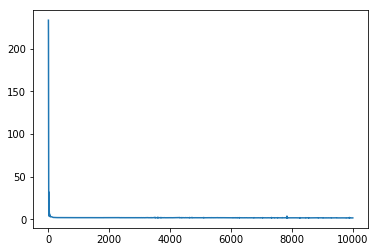

In [69]:
plt.plot(range(len(epoch_losses)), epoch_losses);

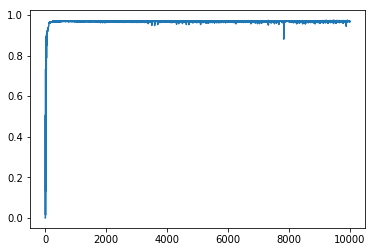

In [70]:
plt.plot(range(len(accuracy)), accuracy);

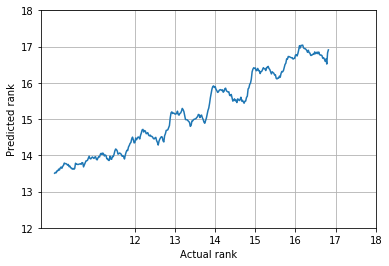

In [75]:
d = []
for x in range(0, len(input_test), 10):
    d.append(model(input_test[x: x+100].astype(float)).mean())
    
plt.plot(np.array(range(len(d))) / 50 + 10, d)
plt.xlabel('Actual rank')
plt.ylabel('Predicted rank')
plt.xticks(list(range(12, 19)))
plt.yticks(list(range(12, 19)));
plt.grid();

In [72]:
input.shape

(35000, 68)

In [82]:
accuracy[-1]

0.9674963396778916

# Ensemble Model

In [272]:
num_columns = len(input.columns)
n_hidden = 32
class RankPredictorEnsemble(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_columns, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden//2),
            nn.ReLU(),
            nn.Linear(n_hidden//2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, game_state):
        game_state = torch.from_numpy(game_state).float().cuda()
        return self.layers(game_state)

[0, 1, 1, 1, 1]


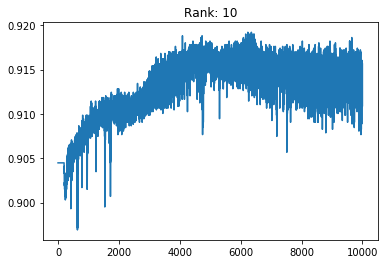

[0, 0, 1, 1, 1]


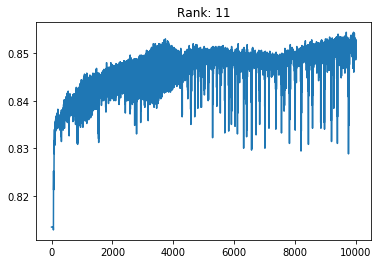

[0, 0, 1, 1, 1]


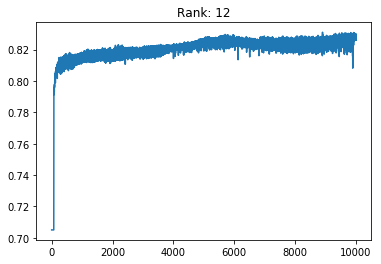

[0, 0, 0, 1, 1]


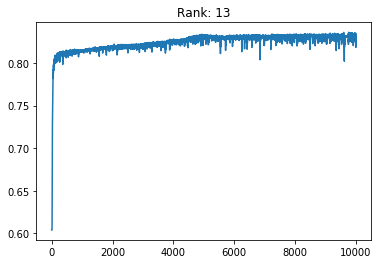

[0, 0, 0, 1, 1]


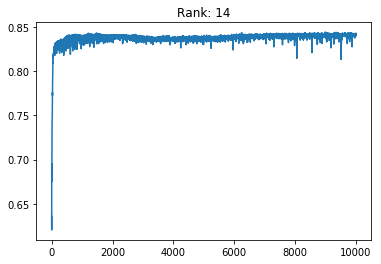

[0, 0, 0, 0, 1]


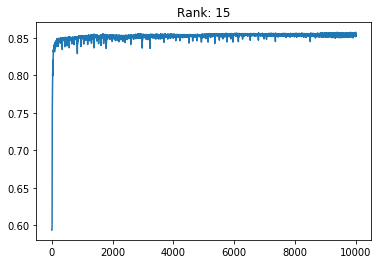

[0, 0, 0, 0, 1]


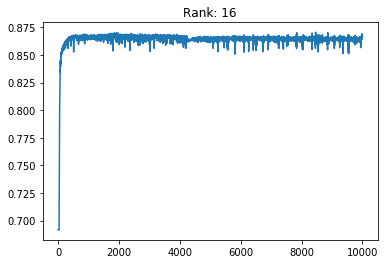

[0, 0, 0, 0, 1]


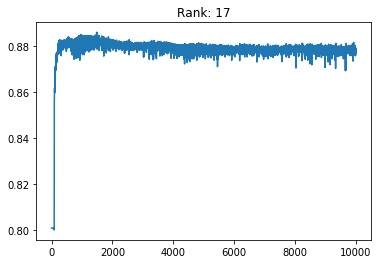

[0, 0, 0, 0, 0]


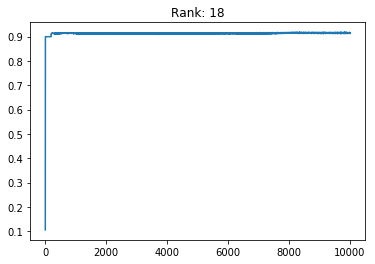

[0, 0, 0, 0, 0]


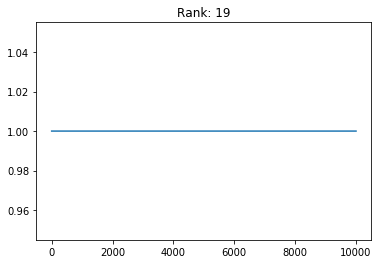

In [216]:
ranks = list(range(10, 20))
models = {}
for rank in ranks:
    models[rank] = RankPredictorEnsemble().cuda()
for rank, model in models.items():
#     if rank != 15:
#         continue
    opt = optim.Adam(model.parameters(), lr=1e-2)
    loss = nn.BCELoss()
    epochs = 1000
    epoch_losses = []
    accuracy = []

    out = (output_train > rank).astype(int)
    print([out[n][0] for n in range(0, len(output_train), len(output_train)//5)])
    output_tensor = torch.from_numpy(out).cuda().float()
    for epoch in range(epochs):
        opt.zero_grad()
        predicted = model(input_train)
        loss_val = loss(predicted, output_tensor)
        loss_val.backward()
        opt.step()

        predicted = model(input_test)
        predicted = predicted.cpu().detach().numpy().astype(float)
    #     print(predicted.shape, output_test.shape)
    #     assert(predicted.shape == output_test.shape)#, "{}, {}".format(predicted.shape, output_test.shape))
        acc = ((predicted > 0.5).astype(int) == (output_test > rank).astype(int)).sum() / predicted.shape[0]
        epoch_losses.append(loss_val.cpu().data.numpy())
        accuracy.append(acc)
    plt.plot(range(len(accuracy)), accuracy);
    plt.title('Rank: {}'.format(rank));
    plt.show();

In [217]:
df_test = None
for rank, model in models.items():
    predicted = pd.Series(model(input_test).detach().cpu().numpy().reshape(len(input_test)), name=str(rank))
    if df_test is None:
        df_test = predicted.to_frame()
    else:
        df_test = df_test.merge(predicted.to_frame(), left_index=True, right_index=True)

In [218]:
df_test.head()

,10,11,12,13,14,15,16,17,18,19
0,0.623275,0.214089,0.134781,0.024251,0.005333,0.000769,0.000779,0.000136,0.000242,9.323475e-13
1,0.872768,0.342160,0.108691,0.096875,0.097184,0.006926,0.000896,0.000174,0.000192,7.603646e-14
2,0.682218,0.427752,0.210606,0.194660,0.110838,0.065109,0.009975,0.000831,0.000217,4.063937e-13
3,0.374761,0.182150,0.297510,0.125759,0.047613,0.034501,0.037275,0.003232,0.002017,1.532654e-13
4,0.911917,0.451472,0.264138,0.045541,0.012533,0.001508,0.000327,0.000057,0.000011,4.246413e-13


In [219]:
results = df_test.apply(lambda x: x > 0.5).apply(lambda x: int(x.idxmin()), axis=1).values

Text(0, 0.5, 'Predicted Rank')

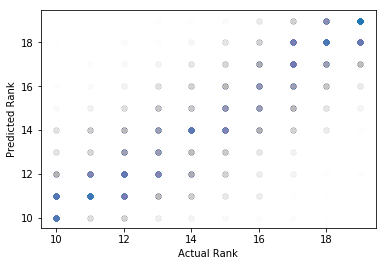

In [220]:
plt.scatter(output_test.reshape(output_test.shape[0]), results, alpha=0.005)
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')

In [237]:
d = []
for i in range(15):
    d.append((abs(results - output_test.reshape(output_test.shape[0])) <= i).sum() * 100 / results.shape[0])
d = pd.DataFrame(d, columns = ['Accuracy (%)'])
d.index.name = 'Rank Difference'
d

,Accuracy (%)
Rank Difference,
0,30.985075
1,67.920398
2,86.407960
3,95.024876
4,98.388060
5,99.502488
6,99.840796
7,99.960199
8,100.000000


In [225]:
results.shape[0]

5025

In [226]:
output_test.reshape(output_test.shape[0])

array([10., 10., 10., ..., 19., 19., 19.])

In [265]:
smurf_data = concat_data([get_playergames_by_id(smurfs[1])])
input_columns = list(smurf_data.columns[11:])
smurf_data = smurf_data[input_columns].iloc[0].values

In [266]:
[m(smurf_data.astype(float)) for m in models.values()]

RuntimeError: size mismatch, m1: [1 x 71], m2: [68 x 32] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:249